In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import time
from scipy import stats

In [2]:
class DataLoader:
    def __init__(self, csv_dir, feature_columns):
        self.csv_dir = csv_dir
        self.feature_columns = feature_columns
        self.EMOTIONS = ['happy', 'sad', 'angry', 'surprise', 'neutral', 'fear', 'disgust']
    
    def extract_emotion(self, filename):
        base = os.path.basename(filename).lower()
        for emotion in self.EMOTIONS:
            if emotion in base: return emotion
        return None
    
    def load_data(self):
        csv_files = glob(os.path.join(self.csv_dir, '*_processed.csv'))
        if not csv_files: csv_files = glob(os.path.join(self.csv_dir, '*.csv'))
        
        all_X, all_y, all_groups = [], [], []
        
        print(f"Loading {len(csv_files)} files...")
        for filename in csv_files:
            emotion = self.extract_emotion(filename)
            if not emotion: continue
            
            try:
                df = pd.read_csv(filename)
                # Check features exist
                if not all(col in df.columns for col in self.feature_columns): continue
                
                feats = df[self.feature_columns].values
                # Remove NaNs
                valid = ~np.any(np.isnan(feats) | np.isinf(feats), axis=1)
                feats = feats[valid]
                
                if len(feats) == 0: continue
                
                all_X.append(feats)
                all_y.extend([emotion] * len(feats))
                # GROUP ID: Use filename so frames from same video stay together
                all_groups.extend([os.path.basename(filename)] * len(feats))
                
            except: continue
            
        if not all_X: return None, None, None
        
        return np.vstack(all_X), np.array(all_y), np.array(all_groups)

In [3]:
BASE_DIR = os.getcwd()

class Config:
    CSV_DIR = os.path.join(BASE_DIR, 'processed_videos')
    SAVE_DIR = os.path.join(BASE_DIR, 'feature_experiments')
    
    # Gaze features
    GAZE_FEATURES = ['gaze_yaw', 'gaze_pitch']
    
    # Action Unit
    AU_FEATURES = [
        'au_shape_dim1', 'au_shape_dim2', 'au_shape_dim3',
        'au_shape_dim4', 'au_shape_dim5', 'au_shape_dim6',
        'au_shape_dim7', 'au_shape_dim8'
    ]
    # Mediapipe 
    POSE_FEATURES = [
        'mp_pose_yaw_deg', 
        'mp_pose_pitch_deg', 
        'mp_pose_roll_deg'
    ]

    # Blendshape (52 features)
    BLENDSHAPE_FEATURES = [
        'bs__neutral',
        'bs_browDownLeft', 'bs_browDownRight', 'bs_browInnerUp',
        'bs_browOuterUpLeft', 'bs_browOuterUpRight',
        'bs_cheekPuff', 'bs_cheekSquintLeft', 'bs_cheekSquintRight',
        'bs_eyeBlinkLeft', 'bs_eyeBlinkRight',
        'bs_eyeLookDownLeft', 'bs_eyeLookDownRight',
        'bs_eyeLookInLeft', 'bs_eyeLookInRight',
        'bs_eyeLookOutLeft', 'bs_eyeLookOutRight',
        'bs_eyeLookUpLeft', 'bs_eyeLookUpRight',
        'bs_eyeSquintLeft', 'bs_eyeSquintRight',
        'bs_eyeWideLeft', 'bs_eyeWideRight',
        'bs_jawForward', 'bs_jawLeft', 'bs_jawOpen', 'bs_jawRight',
        'bs_mouthClose',
        'bs_mouthDimpleLeft', 'bs_mouthDimpleRight',
        'bs_mouthFrownLeft', 'bs_mouthFrownRight',
        'bs_mouthFunnel', 'bs_mouthLeft',
        'bs_mouthLowerDownLeft', 'bs_mouthLowerDownRight',
        'bs_mouthPressLeft', 'bs_mouthPressRight',
        'bs_mouthPucker', 'bs_mouthRight',
        'bs_mouthRollLower', 'bs_mouthRollUpper',
        'bs_mouthShrugLower', 'bs_mouthShrugUpper',
        'bs_mouthSmileLeft', 'bs_mouthSmileRight',
        'bs_mouthStretchLeft', 'bs_mouthStretchRight',
        'bs_mouthUpperUpLeft', 'bs_mouthUpperUpRight',
        'bs_noseSneerLeft', 'bs_noseSneerRight'
    ]

    EYE_BLENDSHAPES = [
        'bs_eyeBlinkLeft', 'bs_eyeBlinkRight',
        'bs_eyeSquintLeft', 'bs_eyeSquintRight',
        'bs_eyeWideLeft', 'bs_eyeWideRight'
    ]
    
    MOUTH_BLENDSHAPES = [
        'bs_jawOpen',
        'bs_mouthSmileLeft', 'bs_mouthSmileRight',
        'bs_mouthFrownLeft', 'bs_mouthFrownRight',
        'bs_mouthPucker', 'bs_mouthFunnel',
        'bs_mouthStretchLeft', 'bs_mouthStretchRight'
    ]

    BROW_BLENDSHAPES = [
        'bs_browDownLeft', 'bs_browDownRight',
        'bs_browInnerUp',
        'bs_browOuterUpLeft', 'bs_browOuterUpRight'
    ]

    KEY_BLENDSHAPES = EYE_BLENDSHAPES + MOUTH_BLENDSHAPES + BROW_BLENDSHAPES

    FEATURE_SETS = {
        # Single feature types
        'AU_Only': AU_FEATURES,
        'Gaze_Only': GAZE_FEATURES,
        'Pose_Only': POSE_FEATURES,
        'Blendshapes_Only': BLENDSHAPE_FEATURES,
        
        # Key subsets
        'Key_Blendshapes': KEY_BLENDSHAPES,
        'Eye_Features': EYE_BLENDSHAPES,
        'Mouth_Features': MOUTH_BLENDSHAPES,
        
        # Combinations
        'AU_Gaze': AU_FEATURES + GAZE_FEATURES,
        'AU_Gaze_Pose': AU_FEATURES + GAZE_FEATURES + POSE_FEATURES,
        'AU_KeyBlendshapes': AU_FEATURES + KEY_BLENDSHAPES,
        'Gaze_Pose_KeyBlendshapes': GAZE_FEATURES + POSE_FEATURES + KEY_BLENDSHAPES,
        
        # Everything
        'All_Features': AU_FEATURES + GAZE_FEATURES + POSE_FEATURES + BLENDSHAPE_FEATURES,
        
        # Your original best
        'Original_Best': GAZE_FEATURES + AU_FEATURES
    }

    # Training parameters
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    RANDOM_STATE = 42
    
    EMOTIONS = ['happy', 'sad', 'angry', 'surprise', 'neutral', 'fear', 'disgust']

config = Config()
os.makedirs(config.SAVE_DIR, exist_ok=True)

print(f"Feature Selection Experiments")
print(f"Testing {len(config.FEATURE_SETS)} feature combinations")

print(f"Available Features:")
print(f"  • Gaze: {len(config.GAZE_FEATURES)} features")
print(f"  • AU Shape: {len(config.AU_FEATURES)} features")
print(f"  • Pose: {len(config.POSE_FEATURES)} features")
print(f"  • Blendshapes: {len(config.BLENDSHAPE_FEATURES)} features")
print(f"  • Key Blendshapes: {len(config.KEY_BLENDSHAPES)} features")
print(f"\nTotal available: {len(config.AU_FEATURES + config.GAZE_FEATURES + config.POSE_FEATURES + config.BLENDSHAPE_FEATURES)} features")

Feature Selection Experiments
Testing 13 feature combinations
Available Features:
  • Gaze: 2 features
  • AU Shape: 8 features
  • Pose: 3 features
  • Blendshapes: 52 features
  • Key Blendshapes: 20 features

Total available: 65 features


In [4]:
all_experiment_results = []

print(f"FEATURE SELECTION EXPERIMENTS")
print(f"{'-'*70}")
print(f"Testing {len(config.FEATURE_SETS)} feature combinations\n")

for experiment_num, (set_name, features) in enumerate(config.FEATURE_SETS.items(), 1):
    
    print(f"\n{'#'*70}")
    print(f"# EXPERIMENT {experiment_num}/{len(config.FEATURE_SETS)}: {set_name}")
    print(f"# Features: {len(features)}")
    print(f"{'#'*70}\n")
    
    start_time = time.time()
    
    try:
        loader = DataLoader(config.CSV_DIR, features) 
        X, y, file_stats = loader.load_data()
        
        if X is None:
            print(f"Failed to load {set_name}. Skipping.\n")
            continue
        
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        
    
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=config.TEST_SIZE + config.VAL_SIZE, 
                                                            stratify=y_encoded, random_state=config.RANDOM_STATE)
        
        val_ratio = config.VAL_SIZE / (config.TEST_SIZE + config.VAL_SIZE)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1 - val_ratio, stratify=y_temp,
                                                        random_state=config.RANDOM_STATE)
        

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        
        simple_grid = {'n_estimators': [300],
                       'max_depth': [20],
                       'min_samples_split': [2],
                       'min_samples_leaf': [1],
                       'max_features': ['sqrt']}
        
        rf_model = RandomForestClassifier(random_state=config.RANDOM_STATE, n_jobs=-1)
        
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.RANDOM_STATE)
        
        grid_search = GridSearchCV(rf_model, simple_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
        
        grid_search.fit(X_train_scaled, y_train)
        
        best_model = grid_search.best_estimator_
        
        train_score = best_model.score(X_train_scaled, y_train)
        val_score = best_model.score(X_val_scaled, y_val)
        test_score = best_model.score(X_test_scaled, y_test)
        
        # Per-class metrics
        y_pred = best_model.predict(X_test_scaled)
        
        from sklearn.metrics import precision_recall_fscore_support
        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred, average=None, labels=range(len(label_encoder.classes_)))
        
        class_metrics = {}
        for i, emotion in enumerate(label_encoder.classes_):
            class_metrics[emotion] = {
                'precision': float(precision[i]),
                'recall': float(recall[i]),
                'f1': float(f1[i]),
                'support': int(support[i])}
        
        elapsed = time.time() - start_time
        
        experiment_result = {
            'feature_set_name': set_name,
            'num_features': len(features),
            'features': features,
            'train_accuracy': float(train_score),
            'val_accuracy': float(val_score),
            'test_accuracy': float(test_score),
            'cv_score': float(grid_search.best_score_),
            'class_metrics': class_metrics,
            'training_time_seconds': elapsed,
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()}
        
        all_experiment_results.append(experiment_result)
        
        exp_dir = os.path.join(config.SAVE_DIR, set_name)
        os.makedirs(exp_dir, exist_ok=True)
        
        joblib.dump(best_model, os.path.join(exp_dir, 'model.pkl'))
        joblib.dump(scaler, os.path.join(exp_dir, 'scaler.pkl'))
        joblib.dump(label_encoder, os.path.join(exp_dir, 'label_encoder.pkl'))
        
        with open(os.path.join(exp_dir, 'results.json'), 'w') as f:
            json.dump(experiment_result, f, indent=2)

        print(f"\n {set_name} Complete!")
        print(f"   Test Accuracy: {test_score:.4f}")
        print(f"   Time: {elapsed:.1f}s")

        
    except Exception as e:
        print(f"\n Error in {set_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

FEATURE SELECTION EXPERIMENTS
----------------------------------------------------------------------
Testing 13 feature combinations


######################################################################
# EXPERIMENT 1/13: AU_Only
# Features: 8
######################################################################

Loading 280 files...

 AU_Only Complete!
   Test Accuracy: 0.7529
   Time: 9.3s

######################################################################
# EXPERIMENT 2/13: Gaze_Only
# Features: 2
######################################################################

Loading 280 files...

 Gaze_Only Complete!
   Test Accuracy: 0.2698
   Time: 9.7s

######################################################################
# EXPERIMENT 3/13: Pose_Only
# Features: 3
######################################################################

Loading 280 files...

 Pose_Only Complete!
   Test Accuracy: 0.6780
   Time: 6.9s

##############################################################

In [5]:
print(f"FINAL RESULTS - ALL FEATURE COMBINATIONS")
print(f"{'-'*70}\n")

if len(all_experiment_results) == 0:
    print("No experiments completed successfully!")
else:
    all_experiment_results.sort(key=lambda x: x['test_accuracy'], reverse=True)
    
    print(f"{'Rank':<6} {'Feature Set':<25} {'#Features':<12} {'Test Acc':<12} {'Time':<10}")
    
    for rank, result in enumerate(all_experiment_results, 1):
        print(f"{rank:<6} {result['feature_set_name']:<25} {result['num_features']:<12} "
              f"{result['test_accuracy']:.4f}       {result['training_time_seconds']:.1f}s")
    
    comparison = {
        'timestamp': datetime.now().isoformat(),
        'experiments': all_experiment_results
    }
    
    with open(os.path.join(config.SAVE_DIR, 'all_results.json'), 'w') as f:
        json.dump(comparison, f, indent=2)
    

FINAL RESULTS - ALL FEATURE COMBINATIONS
----------------------------------------------------------------------

Rank   Feature Set               #Features    Test Acc     Time      
1      All_Features              65           0.9861       29.9s
2      Gaze_Pose_KeyBlendshapes  25           0.9759       19.4s
3      Blendshapes_Only          52           0.9757       27.7s
4      AU_KeyBlendshapes         28           0.9683       17.5s
5      Key_Blendshapes           20           0.9516       18.8s
6      AU_Gaze_Pose              13           0.9462       10.1s
7      Mouth_Features            9            0.8698       14.1s
8      AU_Gaze                   10           0.8198       12.4s
9      Original_Best             10           0.8188       11.8s
10     AU_Only                   8            0.7529       9.3s
11     Eye_Features              6            0.7112       10.5s
12     Pose_Only                 3            0.6780       6.9s
13     Gaze_Only                 2     

In [6]:
BEST_FEATURE_SET = "Gaze_Pose_KeyBlendshapes"
final_features = config.FEATURE_SETS[BEST_FEATURE_SET]

loader = DataLoader(config.CSV_DIR, final_features)
X, y, file_stats = loader.load_data()
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Data Loaded: X shape={X.shape}, y shape={y_encoded.shape}")

Loading 280 files...
Data Loaded: X shape=(53771, 25), y shape=(53771,)


In [7]:
if X is not None:

    feature_stats = pd.DataFrame({
        'Feature': config.FEATURE_SETS[BEST_FEATURE_SET],
        'Mean': np.mean(X, axis=0),
        'Std': np.std(X, axis=0),
        'Min': np.min(X, axis=0),
        'Max': np.max(X, axis=0)
    })
    print(feature_stats.to_string(index=False))

    emotion_counts = Counter(y)
    min_count = min(emotion_counts.values())
    max_count = max(emotion_counts.values())
    imbalance_ratio = max_count / min_count

    print(f"\n Class Balance:")
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
    if imbalance_ratio > 3:
        print("High class imbalance - consider data augmentation or class weights")
    elif imbalance_ratio > 2:
        print("Moderate class imbalance - monitor per-class performance")
    else:
        print("Classes are reasonably balanced")
     

             Feature      Mean      Std           Min       Max
            gaze_yaw -0.223004 0.127195 -1.919312e+00  0.058956
          gaze_pitch  0.004080 0.174133 -2.155140e+00  0.398896
     mp_pose_yaw_deg -0.062604 4.255152 -2.791053e+01 39.381048
   mp_pose_pitch_deg -0.376583 7.613988 -4.482125e+01 40.729716
    mp_pose_roll_deg  1.385455 6.459692 -4.996814e+01 25.233145
     bs_eyeBlinkLeft  0.204377 0.173503  8.276642e-04  0.970968
    bs_eyeBlinkRight  0.198454 0.196143  1.313643e-04  0.987347
    bs_eyeSquintLeft  0.485745 0.169232  5.698661e-03  0.909539
   bs_eyeSquintRight  0.368301 0.184486  3.287770e-03  0.912244
      bs_eyeWideLeft  0.010791 0.018017  3.590479e-05  0.400806
     bs_eyeWideRight  0.014236 0.030435  1.896695e-06  0.884799
          bs_jawOpen  0.132943 0.194819  1.895164e-05  0.952739
   bs_mouthSmileLeft  0.166108 0.286062  2.982591e-08  0.993833
  bs_mouthSmileRight  0.164922 0.290739  1.503028e-08  0.985747
   bs_mouthFrownLeft  0.008094 0.028944 

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded,
    test_size=config.TEST_SIZE + config.VAL_SIZE,
    stratify=y_encoded,
    random_state=config.RANDOM_STATE,
    shuffle=True
)

val_ratio = config.VAL_SIZE / (config.TEST_SIZE + config.VAL_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1 - val_ratio,
    stratify=y_temp,
    random_state=config.RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(f"\n Data split complete:")
print(f"  Training:   {len(X_train):6,d}")
print(f"  Validation: {len(X_val):6,d}")
print(f"  Test:       {len(X_test):6,d}")

# Train Model 
print(f"\nTraining Random Forest...")
best_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=config.RANDOM_STATE
)
best_model.fit(X_train_scaled, y_train)
print("Training Complete.")



 Data split complete:
  Training:   37,639
  Validation:  5,377
  Test:       10,755

Training Random Forest...
Training Complete.


In [9]:
models = {
    'Random Forest': RandomForestClassifier(random_state=config.RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': HistGradientBoostingClassifier(random_state=config.RANDOM_STATE)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 300],
        'max_depth': [10, 20, None],
        'max_features': ['sqrt', 0.5],
        'min_samples_split': [2, 5],
    },
    
    'Gradient Boosting': {
        'max_iter': [100, 200, 300],
        'learning_rate': [0.1, 0.05],
        'max_depth': [None, 10, 20]
    }
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.RANDOM_STATE)

best_model = None
best_test_acc = 0
best_model_name = ''

print(f"STARTING MODEL TRAINING & COMPARISON")
print(f"{'-'*70}")

for name, base_model in models.items():
    print(f"\n Training {name}...")
    start_time = time.time()
    
    grid_search = GridSearchCV(base_model, 
        param_grids[name], 
        cv=cv, 
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    # Evaluate
    current_model = grid_search.best_estimator_
    test_score = current_model.score(X_test_scaled, y_test)
    elapsed = time.time() - start_time
    
    print(f"  • Best Params: {grid_search.best_params_}")
    print(f"  • Test Accuracy:  {test_score:.4f}")
    print(f"  • Time:  {elapsed:.1f}s")
    
    if test_score > best_test_acc:
        best_test_acc = test_score
        best_model = current_model
        best_model_name = name

print(f"\n{'-'*70}")
print(f"BEST MODEL: {best_model_name} (Accuracy: {best_test_acc:.4f})")
print(f"{'-'*70}")

STARTING MODEL TRAINING & COMPARISON
----------------------------------------------------------------------

 Training Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
  • Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
  • Test Accuracy:  0.9786
  • Time:  300.6s

 Training Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
  • Best Params: {'learning_rate': 0.1, 'max_depth': 20, 'max_iter': 300}
  • Test Accuracy:  0.9873
  • Time:  105.7s

----------------------------------------------------------------------
BEST MODEL: Gradient Boosting (Accuracy: 0.9873)
----------------------------------------------------------------------


WINDOWING STRATEGY COMPARISON
----------------------------------------------------------------------
Strategy             Accuracy     Change from Baseline
--------------------------------------------------
Frame_by_Frame       0.9873       baseline
Window_200           0.9630       -0.0243
Window_10            0.9591       -0.0282
Window_30            0.9304       -0.0569
Window_50            0.9259       -0.0613
Window_100           0.9167       -0.0706


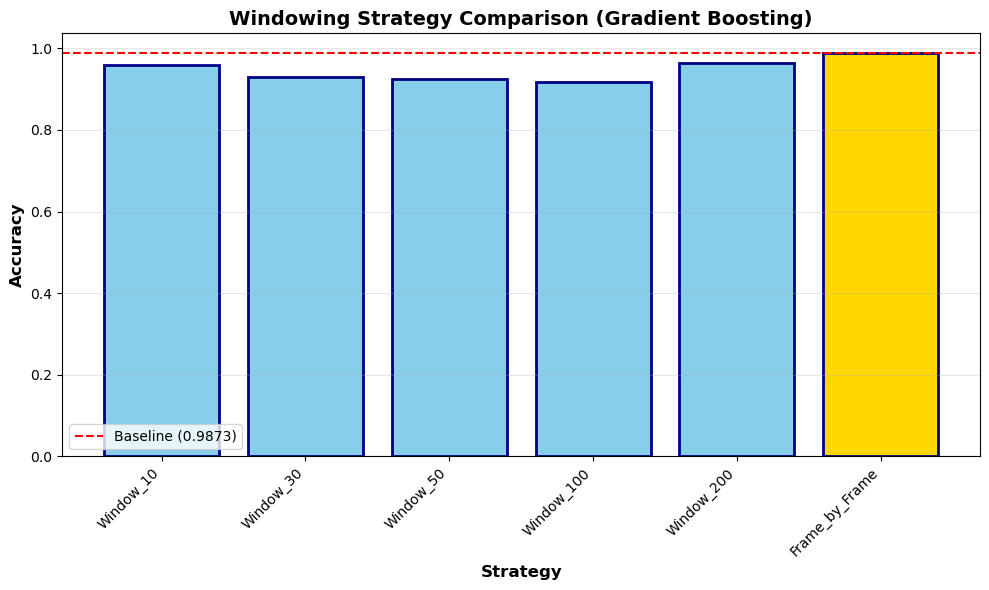


✅ Saved: /Users/keshiaaudrianne/Documents/Northwestern/4 - Senior/Fall/CS 396/cs-396-lightweight-emotion-detection/feature_experiments/windowing_comparison.png
✅ Model saved to disk.


In [10]:
def test_windowing_on_video_predictions(model, X_test, y_test, window_sizes=[10, 30, 50, 100]):
    results = {}
    
    for window_size in window_sizes:
        all_predictions = []
        
        # Step through the data in chunks of 'window_size'
        for i in range(0, len(X_test), window_size):
            window_data = X_test[i:i+window_size]
            window_true = y_test[i:i+window_size]
            
            # Skip incomplete windows at the end
            if len(window_data) < 5: 
                continue
            
            # Get frame-level predictions
            window_preds = model.predict(window_data)
            
            # Take the Mode (most common prediction) for the window
            mode_pred = stats.mode(window_preds, keepdims=True)[0][0]
            mode_true = stats.mode(window_true, keepdims=True)[0][0]
            
            all_predictions.append((mode_true, mode_pred))
        
        if all_predictions:
            y_true_agg = [p[0] for p in all_predictions]
            y_pred_agg = [p[1] for p in all_predictions]
            accuracy = accuracy_score(y_true_agg, y_pred_agg)
            results[f'Window_{window_size}'] = accuracy

    # Add baseline frame-by-frame accuracy
    results['Frame_by_Frame'] = accuracy_score(y_test, model.predict(X_test))
    
    return results

print("WINDOWING STRATEGY COMPARISON")
print(f"{'-'*70}")

# Run your function
window_results = test_windowing_on_video_predictions(
    best_model, X_test_scaled, y_test,
    window_sizes=[10, 30, 50, 100, 200]
)

# Print Results Table
print(f"{'Strategy':<20} {'Accuracy':<12} {'Change from Baseline'}")
print("-" * 50)

baseline = window_results['Frame_by_Frame']
for strategy, acc in sorted(window_results.items(), key=lambda x: x[1], reverse=True):
    change = acc - baseline
    change_str = f"{change:+.4f}" if strategy != 'Frame_by_Frame' else "baseline"
    print(f"{strategy:<20} {acc:.4f}       {change_str}")

# --- 4. VISUALIZE WINDOWING RESULTS ---
plt.figure(figsize=(10, 6))
strategies = list(window_results.keys())
accuracies = list(window_results.values())
colors = ['gold' if s == max(window_results, key=window_results.get) else 'skyblue' 
          for s in strategies]

bars = plt.bar(strategies, accuracies, color=colors, edgecolor='navy', linewidth=2)
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline ({baseline:.4f})')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Strategy', fontsize=12, fontweight='bold')
plt.title(f'Windowing Strategy Comparison ({best_model_name})', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save Plot
save_path = os.path.join(config.SAVE_DIR, 'windowing_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: {save_path}")

# Save the best model for future use
joblib.dump(best_model, os.path.join(config.SAVE_DIR, 'best_model_final.pkl'))
print("✅ Model saved to disk.")

In [11]:
best_model = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    max_depth=10,
    random_state=config.RANDOM_STATE
)

print(f"Training {best_model_name}...")
start_time = time.time()
best_model.fit(X_train_scaled, y_train)
elapsed = time.time() - start_time

y_pred = best_model.predict(X_test_scaled)
best_test_acc = accuracy_score(y_test, y_pred)

print(f"Final {best_model_name} Test Accuracy: {best_test_acc:.4f} (Time: {elapsed:.1f}s)")
print("-" * 70)

print("Classification Report (Frame-by-Frame):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\n" + "="*20 + " WINDOWING STRATEGY RESULTS " + "="*20)
window_results = test_windowing_on_video_predictions(best_model, X_test_scaled, y_test, window_sizes=[10, 50, 100, 200])

print(f"{'Strategy':<20} {'Accuracy':<12} {'Change'}")
print("-" * 40)
baseline = window_results.get('Frame_by_Frame', 0)
for strategy, acc in sorted(window_results.items(), key=lambda x: x[1], reverse=True):
    change = acc - baseline
    print(f"{strategy:<20} {acc:.4f}       {change:+.4f}")

Training Gradient Boosting...
Final Gradient Boosting Test Accuracy: 0.9829 (Time: 35.3s)
----------------------------------------------------------------------
Classification Report (Frame-by-Frame):
              precision    recall  f1-score   support

       angry       0.98      0.96      0.97      1424
     disgust       0.97      0.98      0.98      1588
        fear       0.98      0.98      0.98      1481
       happy       0.99      0.99      0.99      1724
     neutral       0.99      0.99      0.99      1374
         sad       0.99      0.99      0.99      1586
    surprise       0.98      0.98      0.98      1578

    accuracy                           0.98     10755
   macro avg       0.98      0.98      0.98     10755
weighted avg       0.98      0.98      0.98     10755


==================== WINDOWING STRATEGY RESULTS ====================
Strategy             Accuracy     Change
----------------------------------------
Frame_by_Frame       0.9829       +0.0000
Window_2


Calculating Permutation Feature Importance (this may take a moment)...


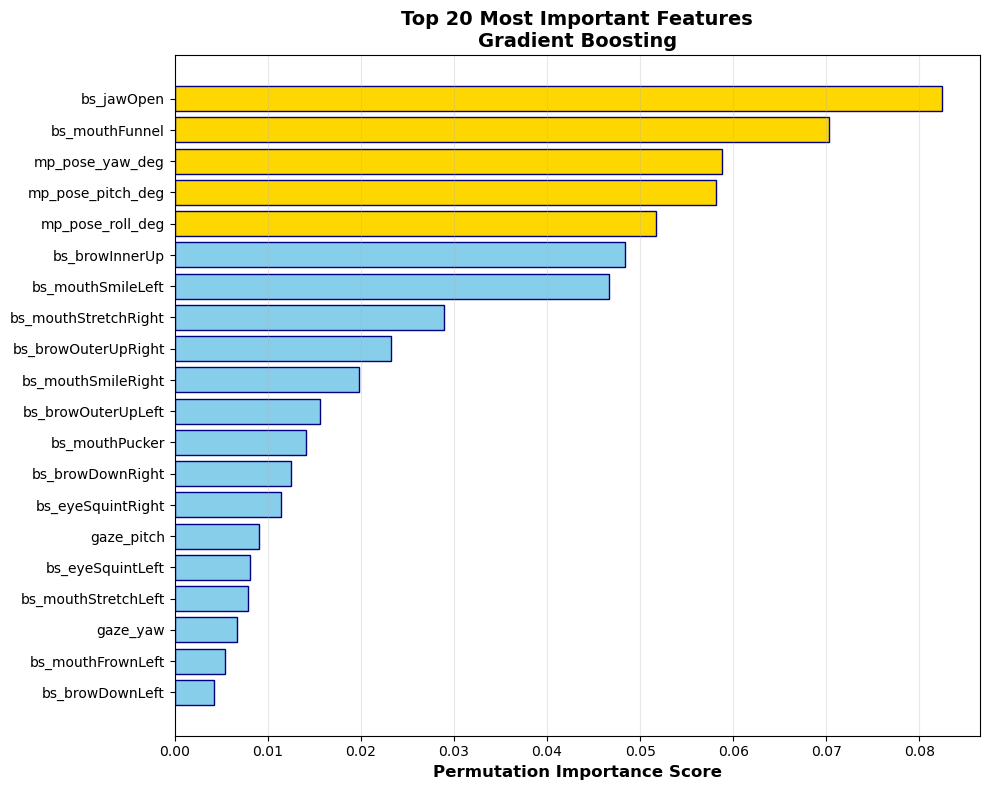

Feature importance plot saved to: /Users/keshiaaudrianne/Documents/Northwestern/4 - Senior/Fall/CS 396/cs-396-lightweight-emotion-detection/feature_experiments/feature_importance_gb.png


In [12]:
# --- STEP 4: PLOTTING SETUP ---
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("\nCalculating Permutation Feature Importance (this may take a moment)...")
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
importances = perm_importance.importances_mean
feature_names_all = config.GAZE_FEATURES + config.POSE_FEATURES + config.KEY_BLENDSHAPES
importance_df = pd.DataFrame({
    'Feature': feature_names_all,
    'Importance': importances
}).sort_values('Importance', ascending=False)

top_n = 20
top_features = importance_df.head(top_n)

# --- 5. PLOT FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 8))
# Color top 5 gold, rest skyblue
colors = ['gold' if i < 5 else 'skyblue' for i in range(len(top_features))]
plt.barh(range(len(top_features)), top_features['Importance'], color=colors, edgecolor='navy')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Permutation Importance Score', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features\n{best_model_name}', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

# Save and Show
save_path = os.path.join(config.SAVE_DIR, 'feature_importance_gb.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Feature importance plot saved to: {save_path}")